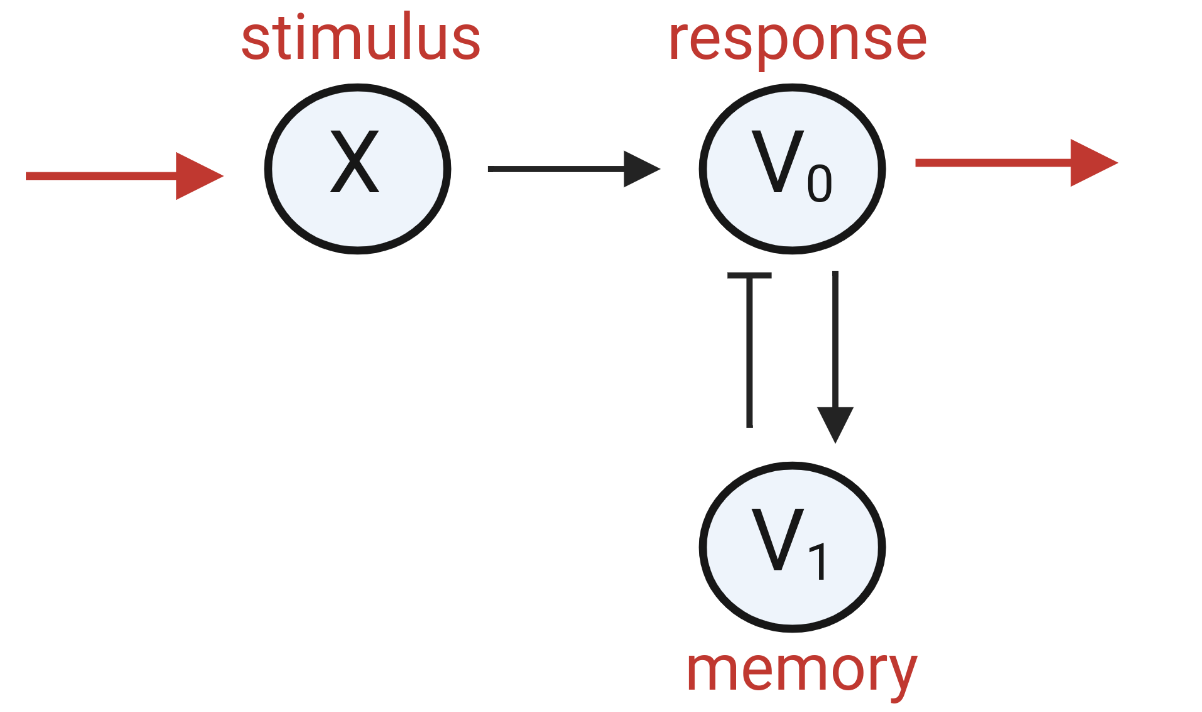


**Response amplitude**

$$V_{0}(t)= \left\{\begin{matrix}
X-V_{1} \text{  if   } (X-V_{1} > \theta) \\
0  \text{  otherwise }
\end{matrix}\right.$$

**Memory** (integrador)
$$V_{1}(t+1) = aV_{1}(t) + bV_0(t) $$

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import linalg as LA
from scipy.signal import find_peaks
from calc_util import sliding_maxnorm_ht


# color settings
cmap = matplotlib.cm.get_cmap('Blues')
colors = [cmap(0.99), cmap(0.8), cmap(0.6), cmap(0.4), cmap(0.2)]

# **Staddon 1996 - single motif**

In [2]:
class OFF:
    def __init__(self, a=1-np.exp(-6.3), b=np.exp(-1.5), rate_input = 2, tita= 0.0, recovery=0, recovery_step = 1 , tMAX=100):

        self.a = a
        self.b = b
        self.rate_input = int(rate_input)
        self.tita = tita
        self.recovery = int(recovery)
        self.recovery_step = int(recovery_step)


        self.tMIN = 0.0
        self.tMAX = tMAX # in secs
        self.dt = 1.0 # in secs
        self.tvec = np.arange(self.tMIN, self.tMAX, self.dt)

        input = [int(i%self.rate_input == 0) for i in range(len(self.tvec)) ]
        self.input = np.array(input)
        if self.recovery:
            self.tvec = np.arange(self.tMIN, self.tMAX + self.recovery_step, self.dt)
            self.input = np.zeros(len(self.tvec))
            self.input[:self.tMAX] = np.array(input)
            self.input[self.tMAX:] = 0.0
            self.timestep = int(self.tMAX -2 + self.recovery_step)
            self.input[self.timestep] = 1.0 # stimulation at end of recovery_step

        self.V_1 = None
        self.V_0 = None


    def run(self, y0=[0.0,0.0]):
        """
        Runs the model.
        """
        lent = len(self.tvec)
        # allocate space for result
        self.V_1 = np.zeros(lent)
        self.V_0 = np.zeros(lent)
        self.V_1[0] = y0[1]
        for n in range(lent-1):
            V_s = self.input[n]  - self.V_1[n]
            if ((V_s-self.tita)>0):
                self.V_0[n] = V_s
            else:
                self.V_0[n] = 0.0
            self.V_1[n+1] = self.a*self.V_1[n] + self.b*self.V_0[n]

In [3]:
# initialize
envelope10, envelope30, envelope60 = [], [], []
timestep10, timestep30, timestep60 = [], [], []
recovery_time_steps = [1, 300, 600, 900, 1200, 1500, 1800]

# run the model
model_10 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*10, rate_input = 10)
model_10.run()
model_30 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*30, rate_input = 30)
model_30.run()
model_60 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*60, rate_input = 60)
model_60.run()

# extract peaks from output variable V_0
peaks10, _ = find_peaks(model_10.V_0)
peaks10 = np.insert(peaks10, 0, 0, axis=0) # agrega el t=0 a los picos
peaks30, _ = find_peaks( model_30.V_0)
peaks30 = np.insert(peaks30, 0, 0, axis=0) # agrega el t=0 a los picos
peaks60, _ = find_peaks(model_60.V_0)
peaks60 = np.insert(peaks60, 0, 0, axis=0) # agrega el t=0 a los picos

# calculate ht
ht10 = sliding_maxnorm_ht(model_10.V_0[peaks10], ht_threshold=0.01)
ht30 = sliding_maxnorm_ht(model_30.V_0[peaks30], ht_threshold=0.01)
ht60 = sliding_maxnorm_ht(model_60.V_0[peaks60], ht_threshold=0.01)

# calculate recovery envelope
for recovery_step in recovery_time_steps:
    model_10 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*10, rate_input = 10, recovery=1, recovery_step = recovery_step)
    model_10.run()
    envelope10.append(model_10.V_0[model_10.timestep])
    timestep10.append(model_10.timestep)
    model_30 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*30, rate_input = 30, recovery=1, recovery_step = recovery_step)
    model_30.run()
    envelope30.append(model_30.V_0[model_30.timestep])
    timestep30.append(model_30.timestep)
    model_60 = OFF(a=1-np.exp(-7.0), b=np.exp(-2.0), tMAX=30*60, rate_input = 60, recovery=1, recovery_step = recovery_step)
    model_60.run()
    envelope60.append(model_60.V_0[model_60.timestep])
    timestep60.append(model_60.timestep)

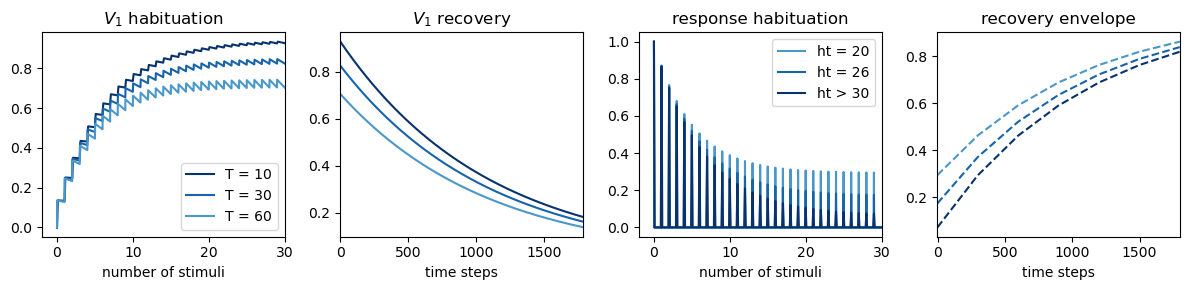

In [4]:
# plot memory increase and decay
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 3))

ax=axes[0] # habituation memory
#ax.plot(model_10.tvec[peaks10]/10, model_10.V_1[peaks10], "o-",  color=colors[0])
#ax.plot(model_30.tvec[peaks30]/30, model_30.V_1[peaks30], "o-",  color=colors[1])
#ax.plot(model_60.tvec[peaks60]/60, model_60.V_1[peaks60], "o-",  color=colors[2])
ax.plot(model_10.tvec/10, model_10.V_1, color=colors[0], label= "T = 10")
ax.plot(model_30.tvec/30, model_30.V_1, color=colors[1], label= "T = 30")
ax.plot(model_60.tvec/60, model_60.V_1, color=colors[2], label= "T = 60")
ax.set_title(r"$V_{1}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.legend()

ax=axes[1] # recovery memory
ax.plot(model_10.V_1[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_1[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_1[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{1}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')

ax=axes[2] # habituation out
ax.plot(model_60.tvec/60, model_60.V_0, label= "ht = "+str(ht60), color=colors[2])
ax.plot(model_30.tvec/30, model_30.V_0, label= "ht = "+str(ht30), color=colors[1])
ax.plot(model_10.tvec/10, model_10.V_0, label= "ht > 30", color=colors[0])
#ax.plot(model_10.tvec[peaks10]/10, model_10.V_0[peaks10], "o", label= "ht > 30",  color=colors[0])
#ax.plot(model_30.tvec[peaks30]/30, model_30.V_0[peaks30], "o", label= "ht = "+str(ht30),  color=colors[1])
#ax.plot(model_60.tvec[peaks60]/60, model_60.V_0[peaks60], "o", label= "ht = "+str(ht60),  color=colors[2])
ax.set_title("response habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.legend()

ax=axes[3] # recovery envelope
t10 = [x-model_10.tMAX for x in timestep10]
t30 = [x-model_30.tMAX for x in timestep30]
t60 = [x-model_60.tMAX for x in timestep60]
ax.plot(t10, envelope10, '--', color=colors[0])
ax.plot(t30, envelope30, '--', color=colors[1])
ax.plot(t60, envelope60, '--', color=colors[2])
ax.set_title("recovery envelope")
ax.set_xlim((-2,1800))
ax.set_xlabel('time steps')

#sns.despine()
plt.tight_layout()
plt.savefig("staddon_1996_single_NF.png", dpi=500)
plt.show()

# **5 cascade feedback model**

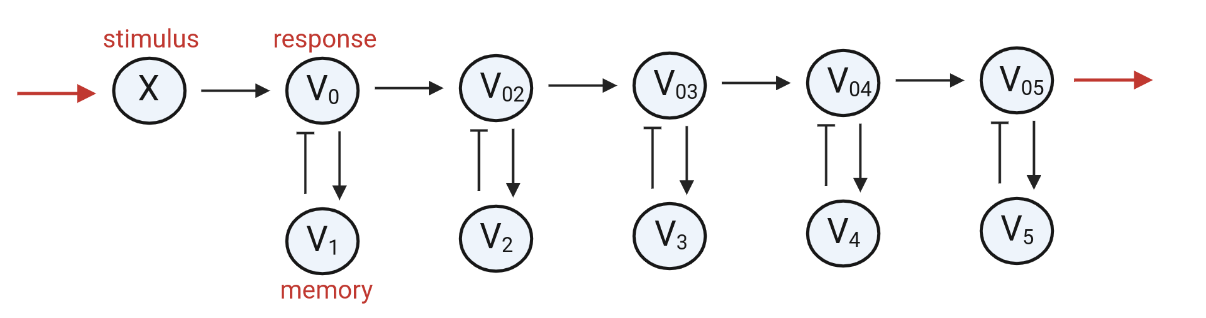

In [5]:
import numpy as np
from numpy import linalg as LA
class OFF:
    def __init__(self, lambda_a=1.9, lambda_b=0.9, rate_input = 2, tita= 0.0, recovery=0, recovery_step = 1 , tMAX=100):

        self.lambda_a = lambda_a
        self.lambda_b = lambda_b
        self.rate_input = int(rate_input)
        self.tita = tita
        self.recovery = int(recovery)
        self.recovery_step = int(recovery_step)

        self.tMIN = 0.0
        self.tMAX = tMAX # in secs
        self.dt = 1.0 # in secs
        self.tvec = np.arange(self.tMIN, self.tMAX, self.dt)

        input = [int(i%self.rate_input == 0) for i in range(len(self.tvec)) ]
        self.input = np.array(input)
        if self.recovery:
            self.tvec = np.arange(self.tMIN, self.tMAX + self.recovery_step, self.dt)
            self.input = np.zeros(len(self.tvec))
            self.input[:self.tMAX] = np.array(input)
            self.input[self.tMAX:] = 0.0
            self.timestep = int(self.tMAX -2 + self.recovery_step)
            self.input[self.timestep] = 1.0

        self.V_1 = None
        self.V_0 = None
        self.V_2 = None
        self.V_02 = None
        self.V_3 = None
        self.V_03 = None
        self.V_4 = None
        self.V_04 = None
        self.V_5 = None
        self.V_05 = None


    def run(self, y0=[0.0,0.0,0.0,0.0,0.0]):
        """
        Runs the model.
        """
        lent = len(self.tvec)
        # allocate space for result
        self.V_1 = np.zeros(lent)
        self.V_0 = np.zeros(lent)
        self.V_2 = np.zeros(lent)
        self.V_02 = np.zeros(lent)
        self.V_3 = np.zeros(lent)
        self.V_03 = np.zeros(lent)
        self.V_4 = np.zeros(lent)
        self.V_04 = np.zeros(lent)
        self.V_5 = np.zeros(lent)
        self.V_05 = np.zeros(lent)
        self.V_1[0] = y0[0]
        self.V_2[0] = y0[1]
        self.V_3[0] = y0[2]
        self.V_4[0] = y0[3]
        self.V_5[0] = y0[4]
        for n in range(lent-1):
            V_s = self.input[n]  - self.V_1[n]
            if ((V_s-self.tita)>0):
                self.V_0[n] = V_s
            else:
                self.V_0[n] = 0.0
            self.V_1[n+1] = (1-np.exp(-self.lambda_a))*self.V_1[n] + (np.exp(-self.lambda_b))*self.V_0[n]

            V_s2 = self.V_0[n]  - self.V_2[n]
            if ((V_s2-self.tita)>0):
                self.V_02[n] = V_s2
            else:
                self.V_02[n] = 0.0
            self.V_2[n+1] = (1-np.exp(-2*self.lambda_a))*self.V_2[n] + (np.exp(-2*self.lambda_b))*self.V_02[n]

            V_s3 = self.V_02[n]  - self.V_3[n]
            if ((V_s3-self.tita)>0):
                self.V_03[n] = V_s3
            else:
                self.V_03[n] = 0.0
            self.V_3[n+1] = (1-np.exp(-3*self.lambda_a))*self.V_3[n] + (np.exp(-3*self.lambda_b))*self.V_03[n]

            V_s4 = self.V_03[n]  - self.V_4[n]
            if ((V_s4-self.tita)>0):
                self.V_04[n] = V_s4
            else:
                self.V_04[n] = 0.0
            self.V_4[n+1] = (1-np.exp(-4*self.lambda_a))*self.V_4[n] + (np.exp(-4*self.lambda_b))*self.V_04[n]

            V_s5 = self.V_04[n]  - self.V_5[n]
            if ((V_s5-self.tita)>0):
                self.V_05[n] = V_s5
            else:
                self.V_05[n] = 0.0
            self.V_5[n+1] = (1-np.exp(-5*self.lambda_a))*self.V_5[n] + (np.exp(-5*self.lambda_b))*self.V_05[n]


In [16]:
model_10 = OFF(tMAX=300, rate_input = 10)
model_10.run()
model_30 = OFF(tMAX=900, rate_input = 30)
model_30.run()
model_60 = OFF(tMAX=30*60, rate_input = 60)
model_60.run()

peaks10, _ = find_peaks( model_10.V_05)
peaks10 = np.insert(peaks10, 0, 0, axis=0) # agrega el t=0 a los picos
peaks30, _ = find_peaks( model_30.V_05)
peaks30 = np.insert(peaks30, 0, 0, axis=0) # agrega el t=0 a los picos
peaks60, _ = find_peaks( model_60.V_05)
peaks60 = np.insert(peaks60, 0, 0, axis=0) # agrega el t=0 a los picos

# calculate ht
ht10 = sliding_maxnorm_ht(model_10.V_05[peaks10], ht_threshold=0.01)
ht30 = sliding_maxnorm_ht(model_30.V_05[peaks30], ht_threshold=0.01)
ht60 = sliding_maxnorm_ht(model_60.V_05[peaks60], ht_threshold=0.01)

# calculate recovery envelope
envelope10, envelope30, envelope60 = [], [], []
timestep10, timestep30, timestep60 = [], [], []
recovery_time_steps = [0, 1, 300, 600, 900, 1200, 1500, 1800]
for recovery_step in recovery_time_steps:
    model_10 = OFF(lambda_a=1.9, lambda_b=0.9, tMAX=30*10, rate_input = 10, recovery=1, recovery_step = recovery_step)
    model_10.run()
    envelope10.append(model_10.V_05[model_10.timestep])
    timestep10.append(model_10.timestep)
    model_30 = OFF(lambda_a=1.9, lambda_b=0.9, tMAX=30*30, rate_input = 30, recovery=1, recovery_step = recovery_step)
    model_30.run()
    envelope30.append(model_30.V_05[model_30.timestep])
    timestep30.append(model_30.timestep)
    model_60 = OFF(lambda_a=1.9, lambda_b=0.9, tMAX=30*60, rate_input = 60, recovery=1, recovery_step = recovery_step)
    model_60.run()
    envelope60.append(model_60.V_05[model_60.timestep])
    timestep60.append(model_60.timestep)

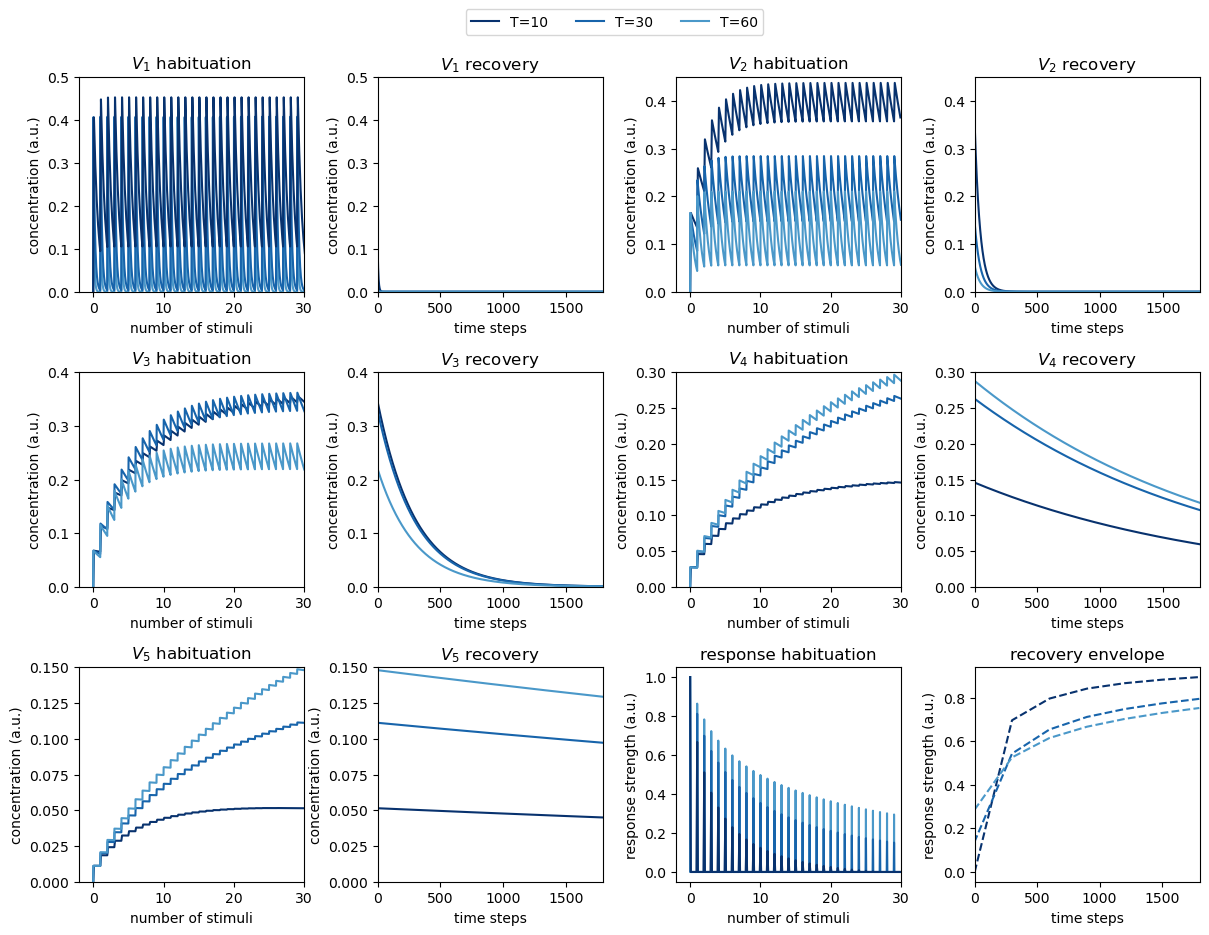

In [17]:
# plot habituation and recovery envelope
#for the recovery decays the x axis is cut a bit before the last test input otherwise the response is plotted and it is distracting
fig, axes = plt.subplots(ncols=4, nrows=3, sharey=False, figsize=(12, 9))

ax=axes[0][0] # motif 1: habituation
ax.plot(model_60.tvec/60, model_60.V_1, color=colors[2])
ax.plot(model_30.tvec/30, model_30.V_1, color=colors[1])
ax.plot(model_10.tvec/10, model_10.V_1, color=colors[0])
ax.set_title(r"$V_{1}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.set_ylim(0,0.5)

ax=axes[0][1] # motif 1: recovery
ax.plot(model_10.V_1[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_1[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_1[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{1}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')
ax.set_ylim(0,0.5)

ax=axes[0][2] # motif 2: habituation
ax.plot(model_10.tvec[:10*30]/10, model_10.V_2[:10*30],  color=colors[0])
ax.plot(model_30.tvec[:30*30]/30, model_30.V_2[:30*30],  color=colors[1])
ax.plot(model_60.tvec[:60*30]/60, model_60.V_2[:60*30],  color=colors[2])
ax.set_title(r"$V_{2}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.set_ylim(0,0.45)

ax=axes[0][3] # motif 2: recovery
ax.plot(model_10.V_2[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_2[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_2[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{2}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')
ax.set_ylim(0,0.45)

ax=axes[1][0] # motif 3: habituation
ax.plot(model_10.tvec/10, model_10.V_3,  color=colors[0])
ax.plot(model_30.tvec/30, model_30.V_3,  color=colors[1])
ax.plot(model_60.tvec/60, model_60.V_3,  color=colors[2])
ax.set_title(r"$V_{3}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.set_ylim(0,0.4)

ax=axes[1][1] # motif 3: recovery
ax.plot(model_10.V_3[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_3[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_3[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{3}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')
ax.set_ylim(0,0.4)

ax=axes[1][2] # motif 4: habituation
ax.plot(model_10.tvec/10, model_10.V_4,  color=colors[0])
ax.plot(model_30.tvec/30, model_30.V_4,  color=colors[1])
ax.plot(model_60.tvec/60, model_60.V_4,  color=colors[2])
ax.set_title(r"$V_{4}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.set_ylim(0,0.3)

ax=axes[1][3] # motif 4: recovery
ax.plot(model_10.V_4[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_4[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_4[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{4}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')
ax.set_ylim(0,0.3)

ax=axes[2][0] # motif 5: habituation
ax.plot(model_10.tvec/10, model_10.V_5,  color=colors[0])
ax.plot(model_30.tvec/30, model_30.V_5,  color=colors[1])
ax.plot(model_60.tvec/60, model_60.V_5,  color=colors[2])
ax.set_title(r"$V_{5}$"+" habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')
ax.set_ylim(0,0.15)

ax=axes[2][1] # motif 5: recovery
ax.plot(model_10.V_5[model_10.tMAX:], color=colors[0])
ax.plot(model_30.V_5[model_30.tMAX:], color=colors[1])
ax.plot(model_60.V_5[model_60.tMAX:], color=colors[2])
ax.set_title(r"$V_{5}$"+" recovery")
ax.set_xlim((0,1790))
ax.set_xlabel('time steps')
ax.set_ylim(0,0.15)

ax=axes[2][2] # habituation output
l60,=ax.plot(model_60.tvec/60, model_60.V_05,  color=colors[2])
l30,=ax.plot(model_30.tvec/30, model_30.V_05,  color=colors[1])
l10,=ax.plot(model_10.tvec/10, model_10.V_05,  color=colors[0])
ax.set_title("response habituation")
ax.set_xlim((-2,30))
ax.set_xlabel('number of stimuli')


ax=axes[2][3] # recovery envelope
t10 = [x-model_10.tMAX for x in timestep10]
t30 = [x-model_30.tMAX for x in timestep30]
t60 = [x-model_60.tMAX for x in timestep60]
ax.plot(t10, envelope10, '--', color=colors[0])
ax.plot(t30, envelope30, '--', color=colors[1])
ax.plot(t60, envelope60, '--', color=colors[2])
ax.set_title("recovery envelope")
ax.set_xlim((-2,1800))
ax.set_xlabel('time steps')

plt.tight_layout()
for row in axes:
    for ax in row:
        ax.set_ylabel("concentration (a.u.)")
ax=axes[2][2]
ax.set_ylabel("response strength (a.u.)")
ax=axes[2][3]
ax.set_ylabel("response strength (a.u.)")
fig.legend([l10,l30,l60],["T=10","T=30","T=60"],
          loc="center",ncol=5,bbox_to_anchor=(0.5,1.02))
plt.savefig("staddon_1996_5xNF.pdf", bbox_inches="tight")
plt.show()